# **Mini-Project B2 Phase 1: Arrhythmia on ECG Classification Using 1D CNN**

In this lab, you will predict different heartbeat arrhythmia on ECG signals. We will be using the [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/).
This database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects.

**Arrhythmia Dataset:**

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    Classes:
    ['Non-ecotic beats (normal beat)':0,
    'Supraventricular ectopic beats': 1,
    'Ventricular ectopic beats': 2,
    'Fusion Beats': 3,
    'Unknown Beats': 4]

# **What is an ECG?**

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.
That's the result of this test we will analyze.

# **1. MIT-BIH Dataset**

### Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

### Dataset Download

In [ ]:
import kagglehub
import os

path1 = kagglehub.dataset_download("shayanfazeli/heartbeat")

base_path = '../root/.cache/kagglehub/datasets/shayanfazeli/heartbeat/versions/1'

print(os.listdir(base_path))

['mitbih_test.csv', 'ptbdb_normal.csv', 'ptbdb_abnormal.csv', 'mitbih_train.csv']


In [ ]:
train_df=pd.read_csv(os.path.join(base_path, 'mitbih_train.csv'),header=None)
test_df=pd.read_csv(os.path.join(base_path, 'mitbih_test.csv'),header=None)

## **1.1 Checking Dataset Imbalance**

In [ ]:
train_df[187]=train_df[187].astype(int)
balance=train_df[187].value_counts()
print(balance)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


## **1.2 Visualize Imbalance**
We can see an imbalance in the dataset above, but it's still hard to visualize exactly how large the imbalance is.

Using Matplotlib create a bargraph or a piechart of our dataset class count.

In [ ]:
# Visualize with bargraph or piechart

'''

YOUR CODE HERE

'''

As we can see, there is a large imbalance in the dataset. We will fix this to try to train a more robust model.

## **1.3 Fixing Data Imbalance**

As we've seen in previous labs, imbalance can negatively affect the performance of machine learning models.
Resampling is a technique used to address class imbalance in datasets, which occurs when certain classes are underrepresented compared to others.

*   **Oversampling (Upsampling):** Increases the number of samples in the minority class by duplicating existing samples or generating new ones (e.g., with techniques like SMOTE). This "upsizes" the smaller class to match the size of the majority class.

* **Undersampling (Downsampling):** Reduces the number of samples in the majority class to match the size of the minority class by randomly removing samples. This "downsizes" the larger class.

### **Resample the Data:**

Using the `resample()` function from `sklearn.utils`, upsample the underrepresented classes to 20,000 samples each.
Concatenate the resampled data to form the new balanced dataset.

Then, using your same visualization method above, visualize the resampled dataset.

In [ ]:
'''

YOUR CODE HERE

'''

In [ ]:
# Check class distribution after resampling
balance=train_df[187].value_counts()

In [ ]:
# Visualize resampled data

''' TODO '''

## **1.4 Checking and Visualizing Data by Class**

We can take one sample per class and display it in a Pandas dataframe. The class labels are listed in column `train_df[187]`:

In [ ]:
class_df =train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
class_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
40552,0.884477,0.808664,0.490975,0.187726,0.086643,0.093863,0.057762,0.046931,0.032491,0.046931,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73895,1.000000,0.874419,0.200000,0.000000,0.074419,0.120930,0.093023,0.139535,0.213953,0.144186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78113,1.000000,0.915575,0.714702,0.475983,0.299854,0.186317,0.117904,0.100437,0.097525,0.078603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80925,1.000000,0.761702,0.482269,0.224113,0.056738,0.076596,0.070922,0.043972,0.034043,0.024113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87384,1.000000,0.517606,0.542253,0.542253,0.517606,0.500000,0.492958,0.447183,0.323944,0.225352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


Let's also check the waveform of our data:

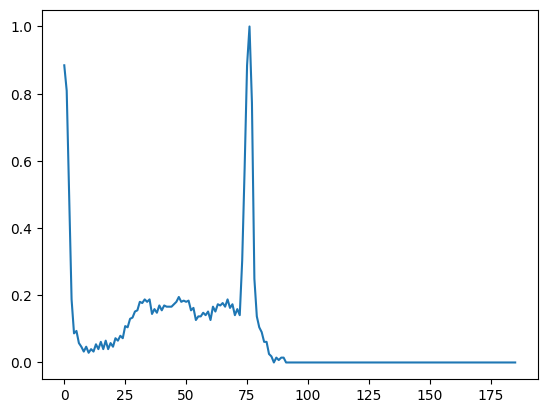

In [ ]:
 plt.plot(class_df.iloc[0,:186])

Here is one waveform of a normal heartbeat.

## **1.5 Plot Heartbeat Waveform for Each Class**

Now that we have a visual idea of what the heartbeat waveforms look like, create subplots to display all classes side by side in a single figure for easier comparison. Ensure each plot is labeled with the corresponding class name above it.

In [ ]:
'''

YOUR CODE HERE

'''


## **1.7 Data Augmentation and Transforms**

In the past, we've applied visual augmentations to image datasets such as CIFAR10 and Stanford Cars. We can also apply augmentations on our time-series dataset to help our model generalize. For time-series data, this can include adding transformations like noise or shifts to simulate variability and reduce overfitting.

**Augmentation Techniques:**
* **Scaling:** Multiply signals by a small random factor.
* **Shifting:** Shift the signal along the time axis.
* **Flipping:** Reverse the signal.
* **Adding Uniform Noise:** Add noise distributed uniformly over a range.

One specific augmentation we will add to our dataset is *Gaussian noise*.

**Gaussian noise** is a random signal characterized by a normal distribution, where most values cluster around a mean (typically 0). When added to a time-series signal, Gaussian noise mimics natural variability and helps models generalize better.

Gaussian noise can be applied by generating a random noise vector of the same length as the signal using np.random.normal() and adding it element-wise to the signal. Adjust the noise's mean and standard deviation to control the intensity of the perturbation.

Apply augmentations to the dataset including, but not limited to, *Gaussian noise* :

In [ ]:
def add_gaussian_noise(signal):

  '''
  YOUR CODE HERE
  '''

  return (signal_with_noise)

# Apply other augmentations of your choosing!

Apply your augmentations, then visualize 2 waveforms from each class with:

*   Original Waveform
*   Augmented Waveform

*Hint:* You can either choose to create your `train_x` dataset here and apply augmentations, or you can apply augmentations to just the selected class waveforms for visualization and create your dataset for training later.

Use the same plotting format above to display each class with corresponding waveforms and class names above:

In [ ]:
'''

YOUR CODE HERE

'''


# **2. Training 1D CNN**

First, we must format our train and test datasets from the downloaded datasets before we can perform training.

*Hint:* Pandas dataframe must be converted to torch tensor to be passed into the model.

Then, create dataloaders for the test and train datasets.

In [ ]:
# Create train and test datasets from dataframe

X_train= ''' TODO '''
X_test= ''' TODO '''

# If you haven't earlier, apply gaussian noise to your X_train

y_train = ''' TODO'''
y_test = ''' TODO '''


In [ ]:
# Create dataloader

train_dataset = ''' TODO '''
test_dataset = ''' TODO '''

train_loader =  ''' TODO '''
test_loader =  ''' TODO '''

## **2.1 Define 1D CNN: ECG-Net!**

**Layer 1 *(Input)*:** Convolutional, input channel = 1, output channel = 64, kernel size = 6, stride = 1, padding = 0.

**Layer 2 (Hidden 1):** Batch Normalization, input channel = 64.

**Layer 3 (Hidden 2):** Max Pooling, kernel size = 3, stride = 2, padding = 1.

**Layer 4 (Hidden 3):** Convolutional, input channel = 64, output channel = 64, kernel size = 3, stride = 1, padding = 0.

**Layer 5 (Hidden 4):** Batch Normalization, input channel = 64.

**Layer 6 (Hidden 5):** Max Pooling, kernel size = 2, stride = 2, padding = 1.

**Layer 7 (Hidden 6):** Fully Connected, input channel = \<you find out\>, output channel = 64.

**Layer 8 (Hidden 7):** Fully Connected, input channel = \<you find out\>, output channel = 32.

**Layer 9 (Output):** Fully Connected, input channel = \<you find out\>, output channel =  \<you find out\>



In [ ]:
class ECGNET(nn.Module):
    ''' TODO '''

Please create `test_accuracy()`, `train()` and `plot_learning_curves()` functions as we have used before.

Then, train your model for 5 epochs and print the loss, accuracy and time taken for training each epoch.

If you would like to aim for accuracy higher than 60%, try adding a scheduler or testing different loss functions.

In [ ]:
def test_accuracy(model, test_loader, device= 'cuda:0'):
    ''' TODO '''

In [ ]:
def plot_learning_curve(''' TODO '''):
    ''' TODO '''

In [ ]:
model = ECGNET(''' TODO ''').cuda()  # Adjust input and output dimensions

optimizer = ''' TODO '''
loss_function = ''' TODO '''
num_epochs = ''' TODO '''
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.4)

# PERFORM TRAINING HERE

''' TODO '''

## **2.2 Model Performance Visualization**

Please visualize your model's performance by plotting learning curves and a confusion matrix of your predictions.

In [ ]:
### TODO

plot_learning_curves('''TODO''')

In [ ]:
def plot_confusion_matrix(''' TODO '''):
    ''' TODO '''

In [ ]:
### TODO

plot_confusion_matrix('''TODO''')

___
___
# End of MiniProject B2 Phase 1 😊🥳